## Download Required Files

To get started, download the following two files:

1. **quality_metrics.csv**
2. **cluster_group.tsv**

Save these files to your computer.



In [27]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import os

import spikeinterface.core as si
import spikeinterface.widgets as sw


# Note, you can set the number of cores you use using e.g.
# si.set_global_job_kwargs(n_jobs = 8)

In [28]:
# In the cell below If you're getting an import error, try adding the root path manually in your notebook:

## how to add root path manually is shown below 
# import sys
# sys.path.append(r"C:\Users\jain\Documents\GitHub\UnitRefine") # path to UnitRefine in locally directory

In [44]:
# Import necessary libraries  
from UnitRefine.scripts.train_manual_curation import train_model

## import from Spikeinterface package
#from spikeinterface.curation import train_model

In [30]:
# Load the data from 'quality_metrics.csv' into a DataFrame
metrics = pd.read_csv('quality_metrics.csv')

# Define a list of column names that correspond to various quality metrics
metrics_cols = [
    'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
    'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
    'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
    'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
    'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
    'drift_ptp', 'drift_std', 'drift_mad', 'isolation_distance', 'l_ratio',
    'd_prime', 'silhouette', 'nn_hit_rate', 'nn_miss_rate'
]


In [31]:
# Load human-curated labels from 'cluster_group.tsv' file
# This file contains information about the quality of each cluster

labels_to_train = pd.read_csv('cluster_group.tsv', sep='\t')  # Read the file, specifying tab as the separator

# Map label names to numerical values:
# 'good' clusters are labeled as 1, while 'mua' (multi-unit activity) and 'noise' are labeled as 0
labels_to_train = labels_to_train['group'].map({'good': 1, 'mua': 0, 'noise': 0}).to_list()


In [32]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: c:\Users\jain\Documents\GitHub\UnitRefine\UnitRefine\tutorial\train_model


### Step: Train the Classifier with Your Data

Load your dataset and the corresponding curated labels to train the classifier. Adjust parameters such as training data size, feature selection, or classifier type to observe their impact on model performance.

**Note:** For improved generalizability, train the model on multiple labeled recordings from varied conditions or sessions.

After training, the model will be saved as `best_model`, which can be used to make predictions on other recordings. The best-performing parameters can be seen using `best_model`.



In [33]:
# We will use a list of two (identical) csv here, we would advise using more than one to improve model performance
trainer = train_model(
    mode = "csv",
    labels = [labels_to_train,labels_to_train],
    metrics_paths = ['quality_metrics.csv','quality_metrics.csv'], # List of paths to the metrics files
    folder = current_directory, # Optional, can be set to save the model and model_info.json file
    metric_names = metrics_cols, # Can be set to specify which metrics to use for training
    imputation_strategies =  ["median"], # Default to all
    scaling_techniques =  ["standard_scaler"], # Default to all
    classifiers = None, # Default to Random Forest only. Other classifiers you can try [ "AdaBoostClassifier","GradientBoostingClassifier",
    test_size=0.2,                                                            # "LogisticRegression","MLPClassifier"]
    overwrite = True
)



Running RandomForestClassifier with imputation median and scaling StandardScaler()
BayesSearchCV from scikit-optimize not available, using RandomizedSearchCV


In [34]:
trainer

In [35]:
best_model = trainer.best_pipeline


In [36]:
# Load and disply top pipelines and accuracies
accuracies = pd.read_csv("model_accuracies.csv", index_col = 0)
accuracies.head()

,classifier name,imputation_strategy,scaling_strategy,balanced_accuracy,precision,recall,model_id,best_params
0,RandomForestClassifier,median,StandardScaler(),0.8766,0.9423,0.8766,0,"{'n_estimators': 150, 'min_samples_split': 2, ..."


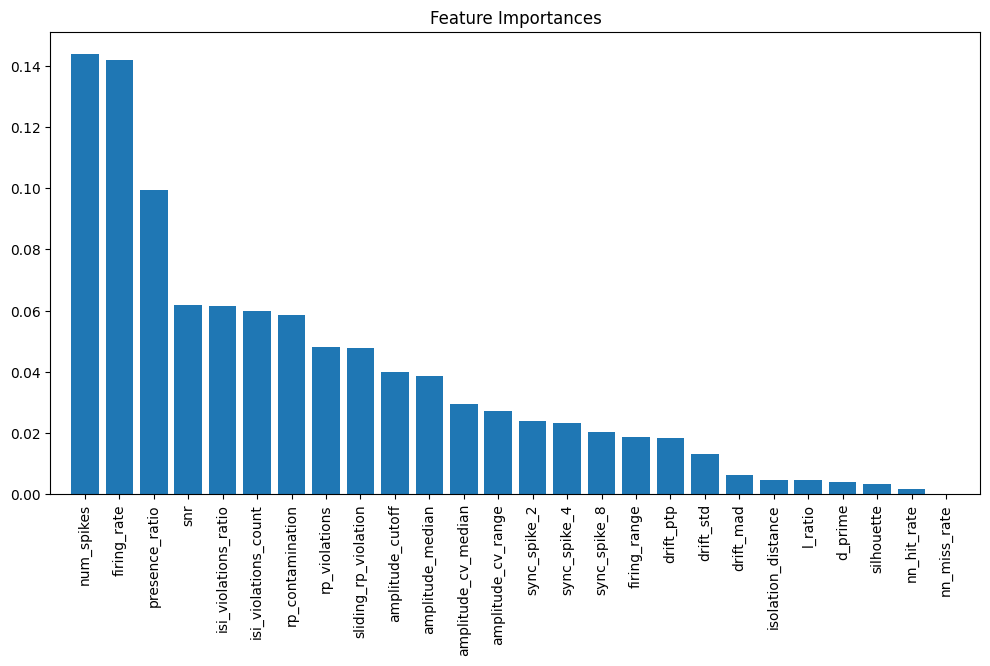

In [37]:
# Plot feature importances
import numpy as np
import matplotlib.pyplot as plt

importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]
features = best_model.feature_names_in_
n_features = best_model.n_features_in_

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(n_features), importances[indices], align="center")
plt.xticks(range(n_features), features, rotation=90)
plt.xlim([-1, n_features])
plt.show()

#Lets apply best_model on new data!

## Load new_data.csv from the UnitRefine folder and apply your best_model on it

In [38]:
# read new csv file
new_data = pd.read_csv('new_data.csv')

In [39]:
new_data.head()

,cluster_id,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,...,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks,velocity_above,velocity_below,exp_decay,spread,cluster_id.1
0,459,7554.0,0.991884,0.825397,12.204892,0.000000,0.0,0.000000,0.0,0.09,...,0.000177,409416.50,-73214.555,1.0,1.0,NaN,1005.7152,0.033996,100.0,459
1,347,48762.0,6.402733,1.000000,5.323073,0.358733,336.0,0.456548,220.0,0.28,...,0.000170,418076.47,-56493.640,1.0,1.0,NaN,495.7309,0.030732,120.0,347
2,178,140.0,0.018383,0.325397,5.208024,0.000000,0.0,0.000000,0.0,NaN,...,0.000180,129573.65,-12767.139,1.0,1.0,NaN,NaN,0.020515,120.0,178
3,87,686.0,0.090076,0.960317,5.549027,0.000000,0.0,0.000000,0.0,NaN,...,0.000170,586757.25,-64506.984,1.0,1.0,412.77590,NaN,0.045614,120.0,87
4,338,15684.0,2.059400,1.000000,8.601093,4.437615,430.0,1.000000,322.0,NaN,...,0.000163,287102.75,-33741.290,2.0,1.0,318.68643,NaN,0.031914,60.0,338


In [40]:
output_labels = best_model.predict(new_data[metrics_cols])

In [41]:
output_probs = best_model.predict_proba(new_data[metrics_cols])

In [42]:
output_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0])

In [43]:
output_probs[:,1]# certainty of predictions for SUA

array([0.83446905, 0.07919947, 0.00614821, 0.31478679, 0.0180758 ,
       0.0372128 , 0.        , 0.        , 0.00570457, 0.65929855,
       0.01871799, 0.        , 0.60592354, 0.00532064, 0.        ,
       0.15258264, 0.00666667, 0.01769188, 0.05125949, 0.42539826,
       0.01333333, 0.01281487, 0.71685796, 0.09081585, 0.        ,
       0.03006311, 0.16147552, 0.        , 0.8666826 , 0.93254515,
       0.92370555, 0.0190379 , 0.01865398, 0.18898043, 0.13891622,
       0.        , 0.0374197 , 0.01306362, 0.79984958, 0.00739171,
       0.00168715, 0.00783535, 0.01502048, 0.        , 0.65753072,
       0.        , 0.        , 0.68482531, 0.        , 0.        ])